In [13]:
%matplotlib inline

import os
import tensorflow as tf
import math
tf.set_random_seed(42)


import keras.backend.tensorflow_backend as K
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, Lambda, BatchNormalization, Activation
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model, load_model
from keras.optimizers import Adam, RMSprop
from keras.initializers import RandomNormal
from keras import regularizers
from sklearn.preprocessing import *
import numpy as np
np.random.seed(42)
np.set_printoptions(threshold=10,linewidth=150)

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt


import argparse
import time
import pickle
import sys
import os
sys.path.append("../")

from physicsfuncs import Minv,cartesian_to_ptetaphi

os.system("mkdir -p outputs/")

0

In [6]:

def train_test_split(*args,**kwargs):
    train_size = 1.-kwargs.get("test_size", 0.5)
    for arg in args:
        n_total = arg.shape[0]
        n_train = int(train_size*n_total)
        train = arg[:n_train]
        test = arg[n_train-n_total:]
        yield train
        yield test
        
def get_mll_from_eptetaphi(x):
    # mll^2 = 2*pt1*pt2*(cosh(eta1-eta2)-cos(phi1-phi2))
    return np.sqrt(2.*x[:,1]*x[:,5]*(np.cosh(x[:,2]-x[:,6])-np.cos(x[:,3]-x[:,7])))


In [7]:
data = np.load("data_xyz.npy")
X_total = data[:,range(1,1+8)]


# N_max_samples = 300000
# use_pt_eta_phi = True
# use_dphi = True
params = {
    "use_pt_eta_phi": True,
    "use_dphi": True,
    "N_max_samples": 300000,
    "output_activation" : "sigmoid",
    "neck_dim" : 5,
    "node_geometry" : "100,50,25",
#     "node_geometry" : "30,20,10",
    "output_shape" : (8,),
    "activation" : "relu",
    "optimizer": "adam",
    "loss": "binary_crossentropy",
    "batch_size": 256,
    "epochs": 10,
}
X_total = X_total[:params["N_max_samples"]]

# convert to Eptetaphi
if params["use_pt_eta_phi"]:
    X_total = cartesian_to_ptetaphi(X_total)
    
    # replace first phi with dphi and second phi with 0
    if params["use_dphi"]: 
        dphi = X_total[:,7] - X_total[:,3]
        dphi[dphi>math.pi] -= 2*math.pi
        dphi[dphi<-math.pi] += 2*math.pi
        X_total[:,3] = dphi
        X_total[:,7] = 0.

print X_total
scaler = MinMaxScaler()
scaler.fit(X_total)
X_total = scaler.transform(X_total)
print X_total

X_train, X_val = train_test_split(X_total, test_size=0.3)
print "Train on", X_train.shape
print "Test on", X_val.shape

[[  1.56576300e+02   9.60537564e+01   1.07069622e+00 ...,   1.24688898e+02   1.67287048e+00   0.00000000e+00]
 [  5.27248800e+01   4.54771014e+01   5.57329020e-01 ...,   4.66361589e+01   6.63905888e-01   0.00000000e+00]
 [  4.61243240e+01   4.40383149e+01  -3.06581235e-01 ...,   4.01997386e+01  -1.13845094e+00   0.00000000e+00]
 ..., 
 [  5.14182540e+01   3.56147643e+01   9.10295569e-01 ...,   3.26759092e+01  -8.03843879e-01   0.00000000e+00]
 [  6.56284710e+01   6.55633096e+01  -4.45501111e-02 ...,   3.26492933e+01  -3.18754460e-01   0.00000000e+00]
 [  5.58817100e+01   3.44845700e+01   1.06319685e+00 ...,   3.67605268e+01  -4.10495233e-01   0.00000000e+00]]
[[ 0.05769162  0.14263615  0.59522087 ...,  0.22189026  0.66632151  0.        ]
 [ 0.01871298  0.06706257  0.55303501 ...,  0.0827665   0.60243981  0.        ]
 [ 0.01623559  0.06491268  0.48204335 ...,  0.07129401  0.48832518  0.        ]
 ..., 
 [ 0.01822257  0.05232589  0.58203997 ...,  0.05788329  0.50951053  0.        ]
 [ 0.

In [8]:
def get_models(params):

    
        # define the autoencoder
    neck_dim = params["neck_dim"]
    output_shape = params["output_shape"]
    activation = params["activation"]
    node_geometry = params["node_geometry"]
    output_activation = params["output_activation"]
    
    
    # define the model
    inputs = Input(shape=output_shape)
    upper_geom = []
    for nodes in node_geometry.split(","):
        upper_geom.append({
            "nodes": int(nodes),
            "activation": activation,
            })
    print upper_geom

    encoded = None
    decoded = None
    for igeom,geom in enumerate(upper_geom):
        to_wrap = inputs if igeom == 0 else encoded
        encoded = Dense(geom["nodes"], activation=geom["activation"])(to_wrap)
    encoded = Dense(neck_dim , activation=activation, name="neck", activity_regularizer=regularizers.l1(1e-5))(encoded)
    for igeom,geom in enumerate(upper_geom[::-1]):
        to_wrap = encoded if igeom == 0 else decoded
        decoded = Dense(geom["nodes"], activation=geom["activation"])(to_wrap)
    decoded = Dense(output_shape[0] , activation=output_activation)(decoded)

    # AUTOENCODER
    autoencoder = Model(inputs, decoded)

    # ENCODER
    encoder = Model(inputs, encoded)

    # DECODER
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(neck_dim,))

    decoder_layer = None
    for ilay in range(-len(upper_geom)-1,0):
        to_wrap = encoded_input if ilay == -len(upper_geom)-1 else decoder_layer
        decoder_layer = autoencoder.layers[ilay](to_wrap)

    decoder = Model(encoded_input, decoder_layer)

    return autoencoder, encoder, decoder

In [9]:
ae, encoder, decoder = get_models(params)
ae.compile(optimizer=params["optimizer"], loss=params["loss"])
ae.summary()

[{'nodes': 100, 'activation': 'relu'}, {'nodes': 50, 'activation': 'relu'}, {'nodes': 25, 'activation': 'relu'}]
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 8)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               900       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
_________________________________________________________________
neck (Dense)                 (None, 5)                 130       
_________________________________________________________________
dense_4 (Dense)              (None, 25)                150       
_____________________________

In [10]:
history = ae.fit(X_train, X_train,
        epochs = params["epochs"],
        batch_size = params["batch_size"],
        shuffle = True,
        validation_data = (X_val, X_val),
                verbose=2)

Train on 210000 samples, validate on 90000 samples
Epoch 1/10
6s - loss: 0.3073 - val_loss: 0.2869
Epoch 2/10
5s - loss: 0.2862 - val_loss: 0.2857
Epoch 3/10
5s - loss: 0.2855 - val_loss: 0.2854
Epoch 4/10
5s - loss: 0.2852 - val_loss: 0.2851
Epoch 5/10
5s - loss: 0.2850 - val_loss: 0.2849
Epoch 6/10
5s - loss: 0.2848 - val_loss: 0.2845
Epoch 7/10
5s - loss: 0.2844 - val_loss: 0.2842
Epoch 8/10
5s - loss: 0.2841 - val_loss: 0.2840
Epoch 9/10
5s - loss: 0.2840 - val_loss: 0.2839
Epoch 10/10
5s - loss: 0.2840 - val_loss: 0.2839


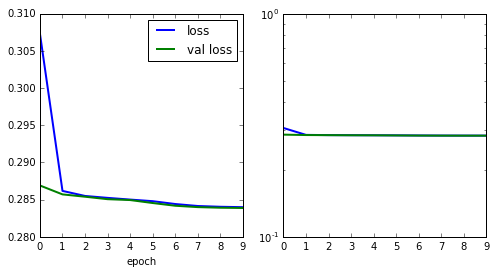

In [14]:
fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].plot(history.history["loss"],"b-",linewidth=2)
axs[0].plot(history.history["val_loss"],"g-",linewidth=2)
axs[0].set_yscale("linear", nonposy='clip')
axs[0].set_xlabel("epoch")
axs[0].legend(["loss","val loss"])

axs[1].plot(history.history["loss"],"b-",linewidth=2)
axs[1].plot(history.history["val_loss"],"g-",linewidth=2)
axs[1].set_yscale("log", nonposy='clip')
axs[0].set_xlabel("epoch")
fig.savefig("outputs/loss_curves.png")

In [15]:
X_val_true_unsc = scaler.inverse_transform(X_val)
print "transformed true"
X_val_ae_unsc = scaler.inverse_transform(ae.predict(X_val))
print "transformed ae"

# add mll to end of X_val matrices
func = Minv
if params["use_pt_eta_phi"]:
    func = get_mll_from_eptetaphi
mllreal = func(scaler.inverse_transform(X_val))
mllae = func(scaler.inverse_transform(ae.predict(X_val)))
X_val_true_unsc = np.c_[X_val_true_unsc,mllreal]
X_val_ae_unsc = np.c_[X_val_ae_unsc,mllae]

print "added mll to end of true and ae"

print X_val_true_unsc
print X_val_ae_unsc


transformed true
transformed ae
added mll to end of true and ae
[[  3.33188430e+01   3.11701062e+01  -3.69195472e-01 ...,  -1.21156889e+00   0.00000000e+00   9.22132899e+01]
 [  1.06681480e+02   3.06046813e+01  -1.92060009e+00 ...,  -5.16373029e-01   0.00000000e+00   9.23662651e+01]
 [  4.02946470e+01   3.06977756e+01  -7.71448164e-01 ...,   1.86290598e+00   0.00000000e+00   1.06332385e+02]
 ..., 
 [  5.14182540e+01   3.56147643e+01   9.10295569e-01 ...,  -8.03843879e-01   0.00000000e+00   9.37679315e+01]
 [  6.56284710e+01   6.55633096e+01  -4.45501111e-02 ...,  -3.18754460e-01   0.00000000e+00   9.09599683e+01]
 [  5.58817100e+01   3.44845700e+01   1.06319685e+00 ...,  -4.10495233e-01   0.00000000e+00   9.14178433e+01]]
[[  5.00738564e+01   4.30002098e+01  -6.04298592e-01 ...,  -1.37281251e+00   7.19325044e-07   9.69771347e+01]
 [  1.43582870e+02   4.51374016e+01  -1.77198172e+00 ...,  -5.91543555e-01   2.44479651e-07   9.27670670e+01]
 [  4.07734566e+01   2.27077236e+01  -8.43568563

In [23]:
# how far off is the mll on average?
avgdmll = np.abs(mllreal-mllae).mean()

7.5526977499074652

/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in divide
/cvmfs/cms.cern.ch/slc6_amd64_gcc630/external/py2-pippkgs/6.0/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in divide


0.117680122441
0.599827858853
14.092400317
0.0118320441221
0.0937592727846
0.52532765589
27.7037538182
0.0
5.38037833089
totalchi2: 48.5249594202


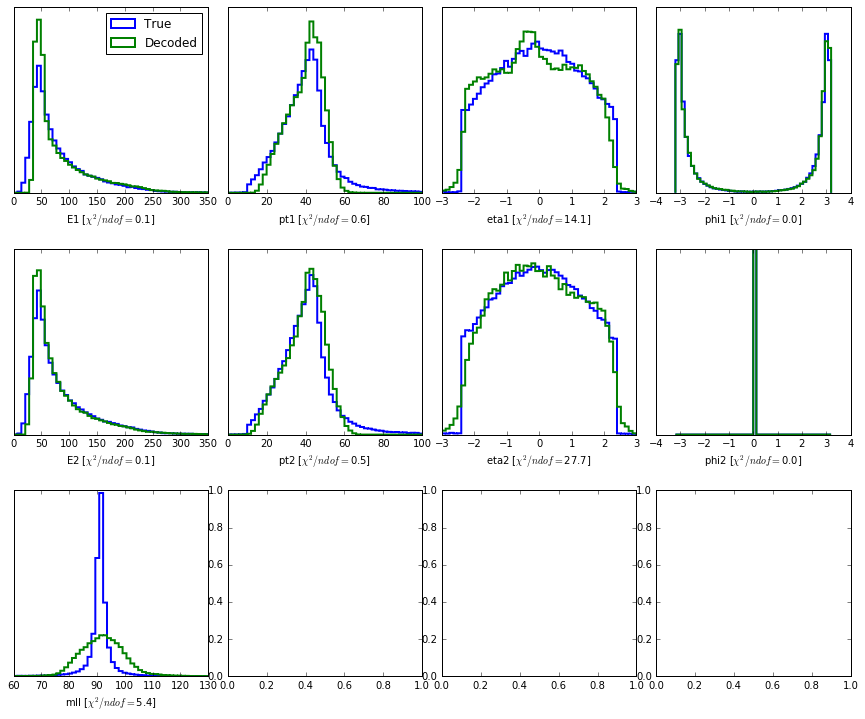

In [16]:
nrows, ncols = 3,4
fig, axs = plt.subplots(nrows,ncols,figsize=(15,12))
fig.subplots_adjust(wspace=0.1,hspace=0.3)

totalchi2 = 0.
# make plots of parameters. must match column ordering. second element is histo range.
if params["use_pt_eta_phi"]:
    info = [
        ("E1",(0,350)),
        ("pt1",(0,100)),
        ("eta1",(-3,3)),
        ("phi1",(-3.2,3.2)),
        ("E2",(0,350)),
        ("pt2",(0,100)),
        ("eta2",(-3,3)),
        ("phi2",(-3.2,3.2)),
        ("mll",(60,130)),
    ]
else:
    info = [
        ("E1",(0,500)),
        ("px1",(-100,100)),
        ("py1",(-100,100)),
        ("pz1",(-100,100)),
        ("E2",(0,500)),
        ("px2",(-100,100)),
        ("py2",(-100,100)),
        ("pz2",(-100,100)),
        ("mll",(60,130)),
    ]
for ic,(cname,crange) in enumerate(info):
    idx = ic // ncols, ic % ncols
    bins_real = axs[idx].hist(X_val_true_unsc[:,ic], range=crange,bins=50, histtype="step", lw=2)
    bins_ae = axs[idx].hist(X_val_ae_unsc[:,ic], range=crange,bins=50, histtype="step", lw=2)
    tosum = np.nan_to_num((bins_real[0]-bins_ae[0])**2/bins_real[0]**2)
    tosum[tosum>1e5] = 0.
    chi2 = np.sum(tosum)/len(bins_real[0])
    print chi2
    totalchi2 += chi2
    chi2 = min(chi2,1e4)
    axs[idx].set_xlabel("{} [$\chi^2/ndof=${:.1f}]".format(cname,chi2))
    axs[idx].get_yaxis().set_visible(False)
    # axs[idx].set_yscale("log", nonposy='clip')
axs[0,0].legend(["True","Decoded"], loc='upper right')
fig.savefig("outputs/kinematics.png")
print "totalchi2:",totalchi2

In [21]:
to_dump = {"params":params, "history":history.history, "totalchi2":totalchi2, "avgdmll": avgdmll}
import pickle
pickle.dump(to_dump,open("outputs/history.pkl","w"))
print "Dumped pickle"

Dumped pickle
